In [1]:
from sklearn.neural_network import MLPRegressor
import numpy as np
import pandas as pd
import data_extraction
import ARIMA
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def ANN_train(X_train, y_train, hidden_layers, alpha=1e-5, random_state=1):
    '''
    INPUT:
    timeseries: TYPE: DataFrame. Contains column named 'residual'
    q: TYPE: Integer. Decides how many historical values to consider
    hidden_layers: TYPE: Tuple of integers. The number on the i'th position decides number of nodes in hidden layer i

    OUTPUT:
    Returns trained model: TYPE: MLPRegressor
    '''
    model = MLPRegressor(solver="lbfgs", 
                         alpha=alpha, 
                         hidden_layer_sizes=hidden_layers, 
                         random_state=random_state, 
                         max_iter=20000,
                         #learning_rate = "adaptive",
                         tol=1e-5) #default tolerance
    model.fit(X_train, y_train)
    return model

In [3]:
past_weeks = 50
hidden_layers = (30, 20, 10)
nRowsRead = None
grid_number = 1

df = pd.read_pickle('forecast.pkl')

def to_datetime(string):
    return datetime.strptime(string, "%Y-%m-%d %H:%M:%S")


def to_string(date):
    return datetime.strftime(date, "%Y-%m-%d %H:%M:%S")


In [4]:
df['residuals'].size

12902

In [5]:
def data_ANN(past_weeks, df):
    # input values
    # past_vals is the number of past values of the residuals that the ANN will use
    residuals = df["residuals"]

    X = []
    y = []
    
    for i in tqdm(range(len(residuals.values) - past_weeks*24*7)):
        X_el = residuals[i:i+24*7*past_weeks:24*7]
        X.append(X_el)
        y.append([residuals.iloc[i+past_weeks*24*7]])
    
    return X, y


In [6]:
X, y = data_ANN(past_weeks, df)


100%|██████████| 4502/4502 [00:00<00:00, 27158.57it/s]


In [7]:
train_size = (len(df)-past_weeks*24*7)-len(data_extraction.get_timeseries("test", nRowsRead, 'loss', grid_number))

#print(len(data_extraction.get_timeseries("train", nRowsRead, 'loss', grid_number))/(24*7))

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

len(X_train)+len(X_test)


4502

In [8]:
model = ANN_train(X_train, y_train, hidden_layers)

In [9]:
def ANN_pred(model, X_test):
    train_size = len(X)-len(data_extraction.get_timeseries("test", nRowsRead, 'loss', grid_number))
    X_test = X_test.copy()
    y_test = []
    for i in tqdm(range(len(X_test))):
        
        X_test_el = X_test[i].values
        
        val = model.predict(X_test_el.reshape(1,-1))

        y_test.append(val[0])

    return y_test



In [10]:
y_pred = ANN_pred(model, X_test)

100%|██████████| 4335/4335 [00:00<00:00, 6736.04it/s]


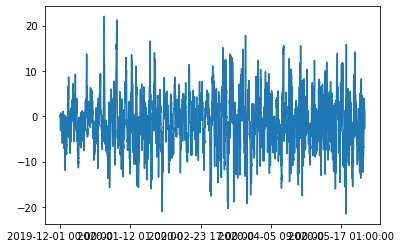

In [11]:
temp = pd.DataFrame(index = data_extraction.get_timeseries("test", nRowsRead, 'loss', grid_number).index)
temp['pred_residuals'] = y_pred
temp = df.join(temp)
(temp['residuals']-temp['pred_residuals']).dropna().plot()

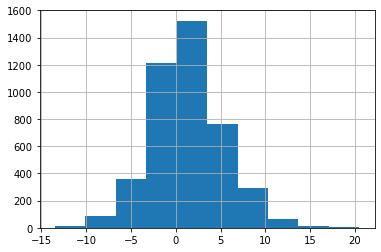

In [12]:
temp["pred_residuals"].hist()

In [13]:
df_from_ANN = pd.read_pickle('ANN_forecast.pkl')

In [14]:
df_from_ANN

,grid1-loss,pred,diff,ann_sum_error,ann_cumsum
2019-12-01 00:00:00,21.55210,21.763823,-0.211723,0.211723,0.211723
2019-12-01 01:00:00,20.71190,21.050540,-0.338640,0.338640,0.550364
2019-12-01 02:00:00,20.27340,20.608945,-0.335545,0.335545,0.885909
2019-12-01 03:00:00,20.25370,20.297191,-0.043491,0.043491,0.929400
2019-12-01 04:00:00,20.40550,20.619203,-0.213703,0.213703,1.143103
...,...,...,...,...,...
2020-05-30 19:00:00,8.55980,15.761028,-7.201228,7.201228,22391.732752
2020-05-30 20:00:00,6.95209,15.596753,-8.644663,8.644663,22400.377415
2020-05-30 21:00:00,8.11558,15.737267,-7.621687,7.621687,22407.999102
2020-05-30 23:00:00,7.26431,15.543540,-8.279230,8.279230,22416.278332


In [15]:
temp = temp.dropna()

temp['Hybrid'] = temp['ARIMA']+temp['pred_residuals']
temp['ANN'] = df_from_ANN['pred']

temp['arima_sum_error'] = abs(temp['grid-loss'] - temp['ARIMA'])
temp['hybrid_sum_error'] = abs(temp['grid-loss'] - temp['Hybrid'])
temp['ann_sum_error'] = df_from_ANN['ann_sum_error']

temp['arima_cumsum'] = temp['arima_sum_error'].cumsum()
temp['hybrid_cumsum'] = temp['hybrid_sum_error'].cumsum()
temp['error_in_res'] = (temp['residuals']-temp['pred_residuals'])
temp['ann_cumsum'] = df_from_ANN['ann_cumsum']

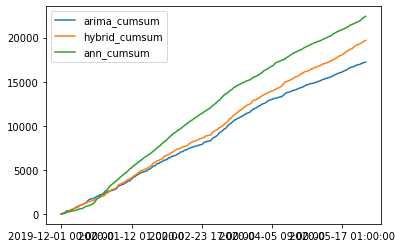

In [16]:
temp[['arima_cumsum','hybrid_cumsum', 'ann_cumsum']].plot()


In [18]:
(temp['arima_cumsum'].iloc[-1]-temp['hybrid_cumsum'].iloc[-1])/temp['arima_cumsum'].iloc[-1]

-0.14315128879664316

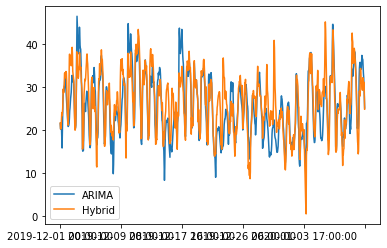

In [19]:
temp[['ARIMA','Hybrid']].loc["2019-11-30 00:00:00":"2020-01-12 00:00:00"].plot()

In [20]:
diff = temp['grid-loss']-temp['Hybrid']
(diff**2).mean()

34.50600740334198

In [21]:
data_extraction.get_timeseries("test", nRowsRead, 'load', grid_number)

2019-12-01 00:00:00    407.67600
2019-12-01 01:00:00    397.96600
2019-12-01 02:00:00    392.90400
2019-12-01 03:00:00    392.72600
2019-12-01 04:00:00    394.47800
                         ...    
2020-05-30 20:00:00    224.54790
2020-05-30 21:00:00    223.84220
2020-05-30 22:00:00    217.77730
2020-05-30 23:00:00    208.35270
2020-05-31 00:00:00    199.86566
Name: grid1-load, Length: 4345, dtype: float64

In [22]:
len(temp['residuals'].dropna())-len(data_extraction.get_timeseries("test", nRowsRead, 'load', grid_number))

-10

In [23]:
abs(temp['error_in_res']).cumsum()

2019-12-01 00:00:00        0.170596
2019-12-01 01:00:00        0.593043
2019-12-01 02:00:00        0.711399
2019-12-01 03:00:00        1.487039
2019-12-01 04:00:00        3.795008
                           ...     
2020-05-30 19:00:00    19673.646562
2020-05-30 20:00:00    19674.723270
2020-05-30 21:00:00    19675.467347
2020-05-30 23:00:00    19678.206415
2020-05-31 00:00:00    19679.569181
Name: error_in_res, Length: 4335, dtype: float64

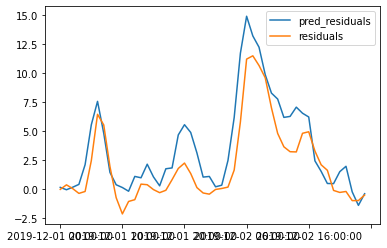

In [24]:
temp[['pred_residuals','residuals']].iloc[:50].plot()

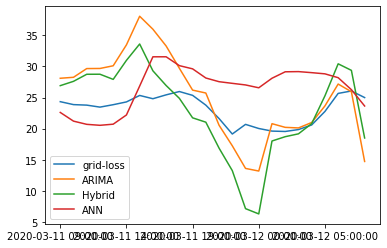

In [25]:
temp[['grid-loss','ARIMA', 'Hybrid', 'ANN']].iloc[2400:2424].plot()